### Tests

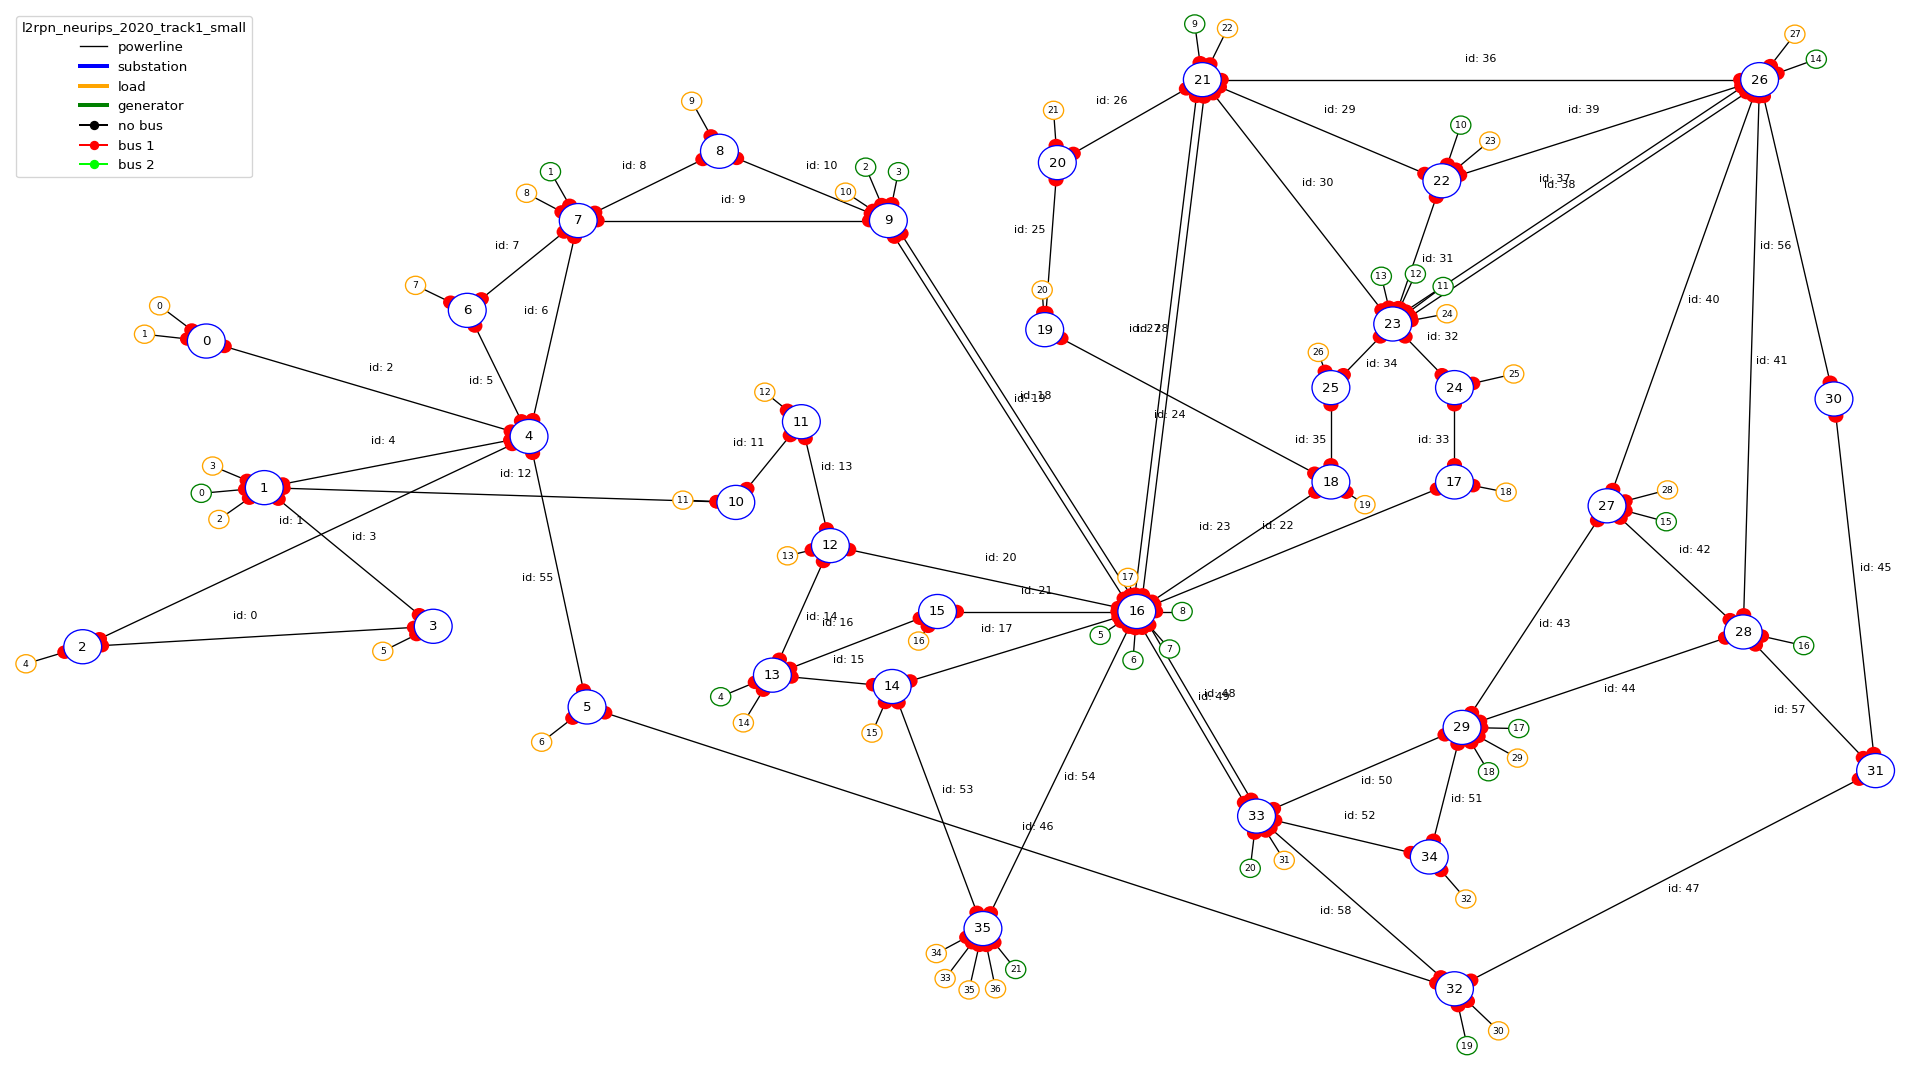

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import grid2op
import tqdm
assert grid2op.__version__ >= "1.1.0", "You need grid2op at least 1.1.0 to compete in this track."
from grid2op.PlotGrid import PlotMatplot

env = grid2op.make("l2rpn_neurips_2020_track1_small")
env.seed(42)  # for reproducible experiments
plot_helper = PlotMatplot(env.observation_space, width=1920, height=1080, line_id=True)
_ = plot_helper.plot_layout()

In [2]:
obs = env.reset()
obs.to_dict().keys()

dict_keys(['timestep_overflow', 'line_status', 'topo_vect', 'loads', 'prods', 'lines_or', 'lines_ex', 'rho', 'maintenance', 'cooldown', 'redispatching'])

In [3]:
print("Number of elements connected to each substations in the powergrid: {}".format(obs.sub_info))
len(obs.sub_info)

Number of elements connected to each substations in the powergrid: [ 3  6  3  3  6  3  3  6  3  7  3  3  4  5  4  3 17  3  4  3  3  8  5 10
  3  3  9  5  5  7  2  3  5  7  3  7]


36

In [4]:
obs.grid_objects_types[:5]

array([[ 0, -1, -1,  2, -1],
       [ 0,  0, -1, -1, -1],
       [ 0,  1, -1, -1, -1],
       [ 1, -1, -1,  3, -1],
       [ 1, -1, -1,  4, -1]], dtype=int32)

In [5]:
pi = np.random.rand(36, 17)
info = env.sub_info
mask = np.zeros_like(pi, dtype = np.bool)
for i, n in enumerate(info):
    mask[i,:n] = 1
x = mask * pi

In [6]:
x[mask].shape

(177,)

## Graph representation: G --> M

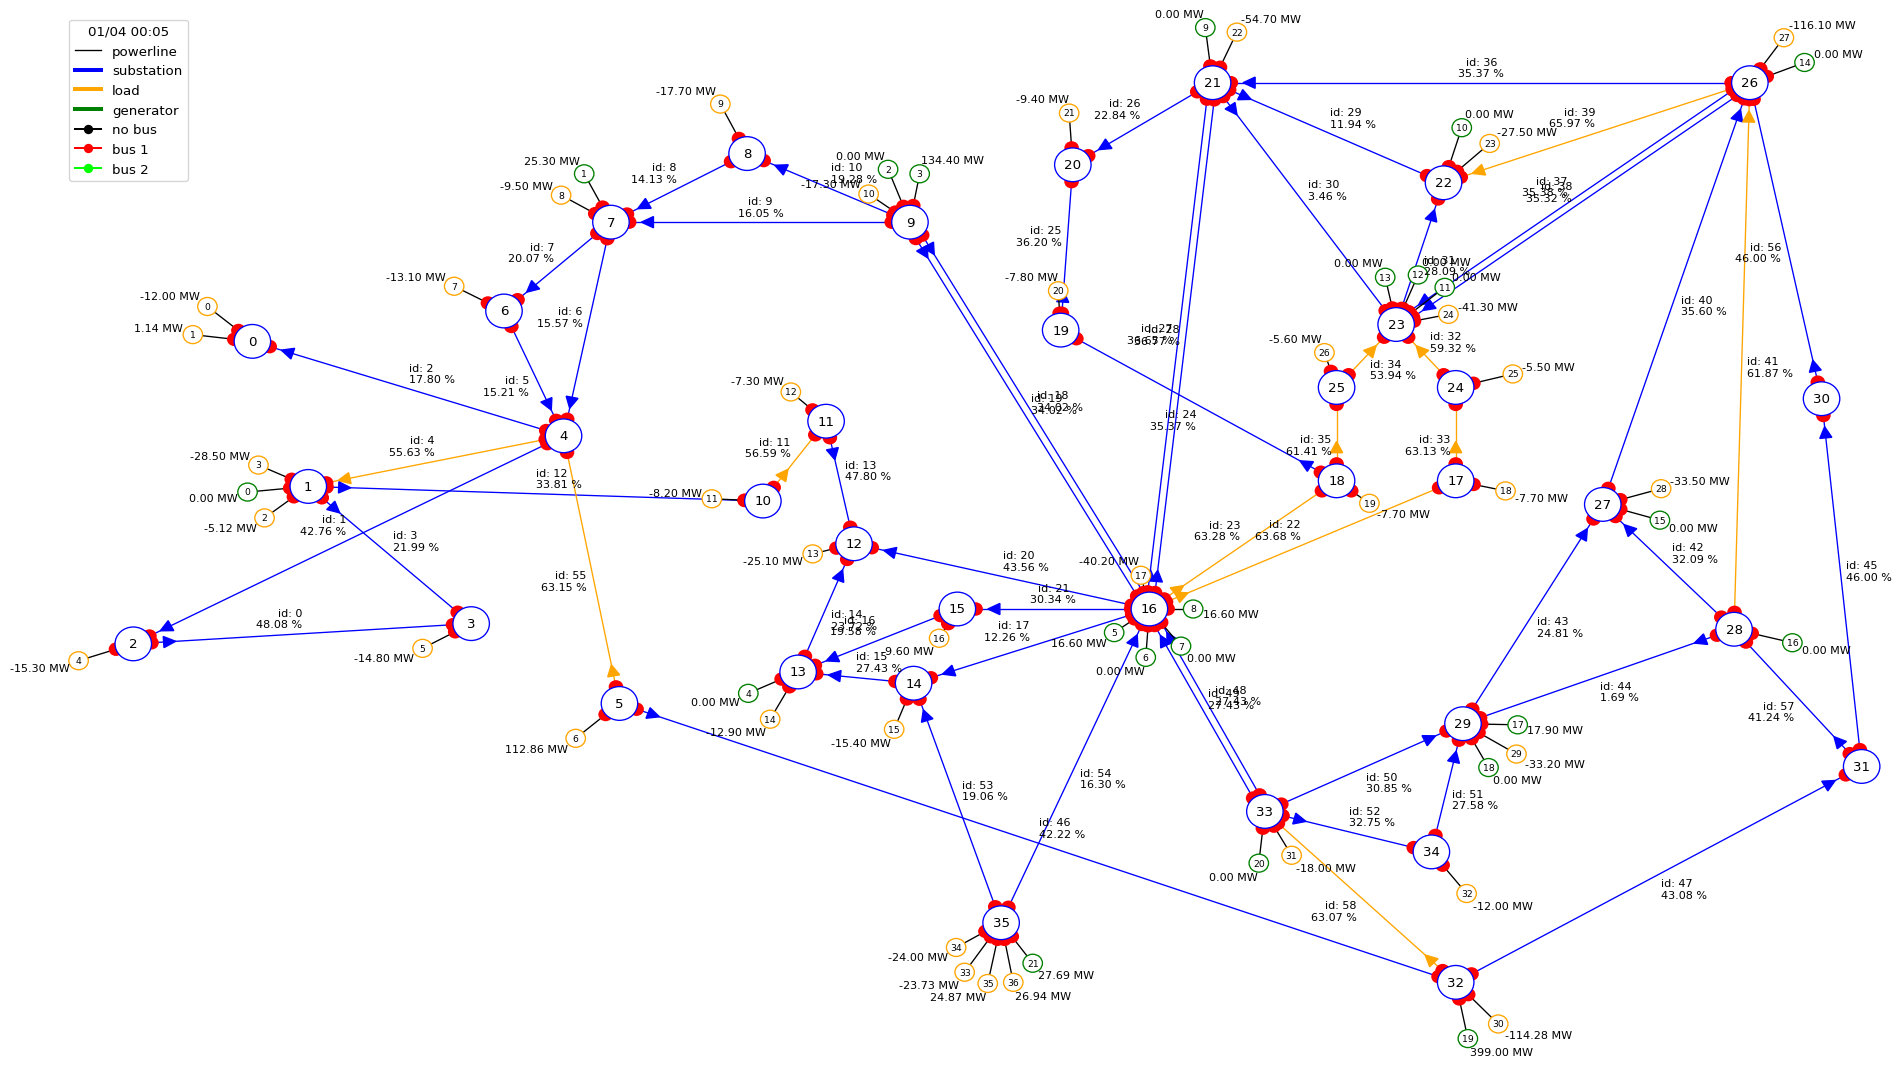

In [6]:
fig = plot_helper.plot_obs(obs)

In [9]:
action = env.action_space()
obs, r, done, info = env.step(action)
r

946.5723

In [7]:
S = []
S.append(obs.connectivity_matrix())
S[0].shape

(177, 177)

In [8]:
lines_or = []
lines_ex = []
for i, x in enumerate(env.grid_objects_types):
    if x[3] >= 0:
        lines_ex.append((i, x[3]))
    if x[4] >= 0:
        lines_or.append((i, x[4]))

In [9]:
print(lines_ex[:5])
print(lines_or[:5])

[(0, 2), (3, 3), (4, 4), (5, 12), (9, 0)]
[(12, 0), (13, 3), (15, 1), (16, 2), (17, 4)]


In [10]:
P = np.zeros_like(obs.connectivity_matrix())
for o in lines_or:
    status = obs.line_status[o[1]]
    for e in lines_ex:
        if o[1] == e[1]:
            P[o[1], o[0]] = obs.rho[o[1]] if status else -1
P

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [11]:
P[P > 0] == obs.rho

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True])

In [59]:
gens_ids = []
loads_ids = []
for i, x in enumerate(env.grid_objects_types):
    if x[1] >= 0:
        loads_ids.append((i, x[1]))
    if x[2] >= 0:
        gens_ids.append((i, x[2]))

In [60]:
G = np.zeros_like(obs.connectivity_matrix())
prods = obs.prod_p / obs.gen_pmax
for g in gens_ids:
    G[g[0], g[0]] = prods[g[1]]
G

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [61]:
L = np.zeros_like(obs.connectivity_matrix())
loads = obs.load_p / obs.prod_p.sum()
for l in loads_ids:
    L[l[0], l[0]] = loads[l[1]]
L

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.01882388,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        , -0.00178827, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.03764777,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
        -0.0390125 ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        , -0.04225962]], dtype=float32)

In [68]:
C = obs.connectivity_matrix()

In [72]:
B = np.zeros_like(C)
topo = obs.topo_vect
for i, t in enumerate(topo):
    B[i, i] = t
B

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [74]:
S = [C, P, G, L, B]
import torch

T = torch.Tensor(S)
T.shape

torch.Size([5, 177, 177])

In [15]:
action_space = env.action_space
change_bus = 0 * obs.topo_vect
change_bus[0] = 1
change_bus[1] = 1
change_bus[2] = 1
change_bus[3] = 1

act = action_space({'change_bus': change_bus})
print(act)

This action will:
	 - NOT change anything to the injections
	 - NOT perform any redispatching action
	 - NOT force any line status
	 - NOT switch any line status
	 - Change the bus of the following element:
	 	 - switch bus of line (origin) 2 [on substation 0]
	 	 - switch bus of load 0 [on substation 0]
	 	 - switch bus of load 1 [on substation 0]
	 	 - switch bus of line (origin) 3 [on substation 1]
	 - NOT force any particular bus configuration


In [89]:
new_obs, reward, done, info = env.step(act)
info

{'disc_lines': array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False]),
 'is_illegal': False,
 'is_ambiguous': False,
 'is_dispatching_illegal': False,
 'is_illegal_reco': False,
 'opponent_attack_line': None,
 'opponent_attack_sub': None,
 'opponent_attack_duration': 0,
 'exception': [Grid2OpException DivergingPowerFlow DivergingPowerFlow('GAME OVER: Powerflow has diverged during computation or a load has been disconnected or a generator has been disconnected.')],
 'rewards': {}}

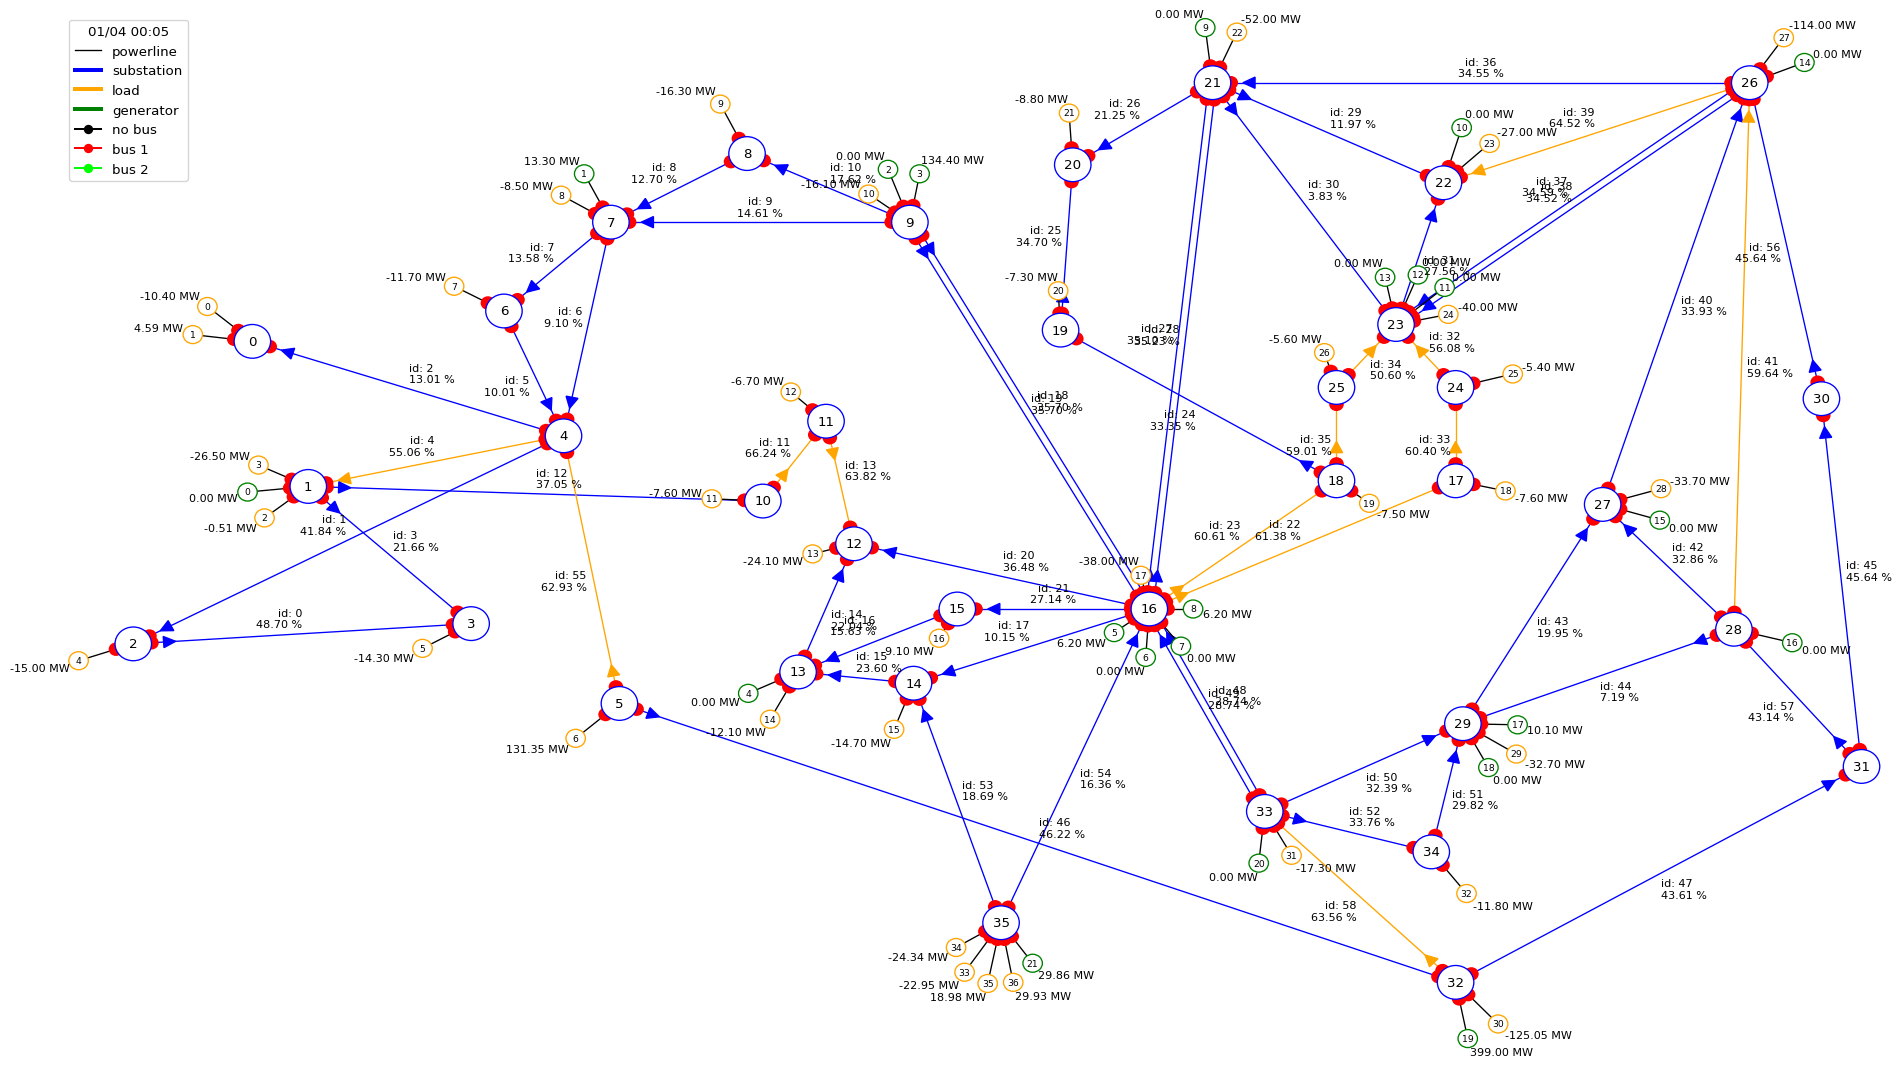

In [90]:
fig = plot_helper.plot_obs(new_obs)

### Benchmark do nothing

In [3]:
N_EPISODES = 20
ep_rewards = []
ep_steps = []
for n in range(N_EPISODES):
    obs = env.reset()
    cum_reward = 0
    steps = 0
    done = False
    while not done:
        do_nothing_act = env.helper_action_player({})
        obs, reward, done, info = env.step(do_nothing_act)
        cum_reward += reward
        steps += 1
    print('Episode %d total_reward: %.2f total_steps: %d' % (n, cum_reward, steps))
    ep_rewards.append(cum_reward)
    ep_steps.append(ep_steps)

Episode 0 total_reward: 121357.71 total_steps: 153
Episode 1 total_reward: 379212.77 total_steps: 389
Episode 2 total_reward: 152865.53 total_steps: 197
Episode 3 total_reward: 666296.84 total_steps: 687
Episode 4 total_reward: 32609.12 total_steps: 39
Episode 5 total_reward: 474601.33 total_steps: 506
Episode 6 total_reward: 80324.18 total_steps: 95
Episode 7 total_reward: 544505.73 total_steps: 570
Episode 8 total_reward: 152084.63 total_steps: 196
Episode 9 total_reward: 354678.52 total_steps: 362
Episode 10 total_reward: 152084.63 total_steps: 196
Episode 11 total_reward: 252738.47 total_steps: 267
Episode 12 total_reward: 151303.60 total_steps: 195
Episode 13 total_reward: 666295.46 total_steps: 687
Episode 14 total_reward: 152084.63 total_steps: 196
Episode 15 total_reward: 112405.89 total_steps: 110
Episode 16 total_reward: 80324.90 total_steps: 95
Episode 17 total_reward: 412806.73 total_steps: 432
Episode 18 total_reward: 2501.46 total_steps: 4
Episode 19 total_reward: 88837.1

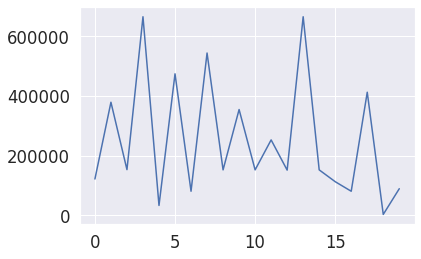

In [4]:
sns.set(style="darkgrid", font_scale=1.5)
sns.lineplot(x = range(len(ep_rewards)), y = ep_rewards, ci = 'sd')

In [ ]:
#sns.lineplot(x = range(len(ep_steps)), y = ep_steps, ci = 'sd')

### Benchmark random

In [5]:
from grid2op.Agent import RandomAgent
my_agent =  RandomAgent(env.action_space)
my_agent.seed(0)

In [6]:
ep_rewards_rn = []
ep_steps_rn = []
for n in range(N_EPISODES):
    obs = env.reset()
    cum_reward = 0
    steps = 0
    done = False
    while not done:
        act = my_agent.act(None, None)
        obs, reward, done, info = env.step(act)
        cum_reward += reward
        steps += 1
    print('Episode %d total_reward: %.2f total_steps: %d' % (n, cum_reward, steps))
    ep_rewards_rn.append(cum_reward)
    ep_steps_rn.append(ep_steps)

Episode 0 total_reward: 4114.69 total_steps: 20
Episode 1 total_reward: 28397.58 total_steps: 96
Episode 2 total_reward: 811.43 total_steps: 4
Episode 3 total_reward: 1048.09 total_steps: 4
Episode 4 total_reward: 2441.98 total_steps: 12
Episode 5 total_reward: 4233.44 total_steps: 12
Episode 6 total_reward: 811.51 total_steps: 4
Episode 7 total_reward: 11614.66 total_steps: 36
Episode 8 total_reward: 811.57 total_steps: 4
Episode 9 total_reward: 33643.68 total_steps: 119
Episode 10 total_reward: 3284.17 total_steps: 12
Episode 11 total_reward: 4195.54 total_steps: 16
Episode 12 total_reward: 1627.93 total_steps: 7
Episode 13 total_reward: 2096.15 total_steps: 8
Episode 14 total_reward: 1653.68 total_steps: 4
Episode 15 total_reward: 26338.37 total_steps: 86
Episode 16 total_reward: 811.64 total_steps: 4
Episode 17 total_reward: 25923.77 total_steps: 96
Episode 18 total_reward: 811.62 total_steps: 4
Episode 19 total_reward: 11541.14 total_steps: 44


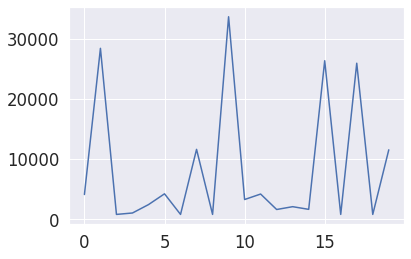

In [7]:
sns.lineplot(x = range(len(ep_rewards_rn)), y = ep_rewards_rn, ci = 'sd')

In [9]:
np.mean(ep_rewards_rn)

8310.631625366212